In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time

%matplotlib inline

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_mask(x,length,sig_RF):
    return (1.+np.exp(-(x + length/2.)/sig_RF) )**-1. * (1. - (1.+np.exp(-(x - length/2.)/sig_RF))**-1. )

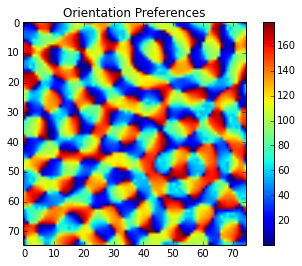

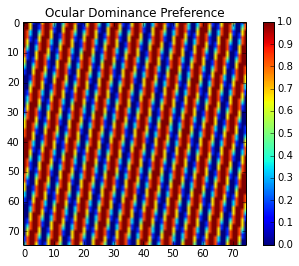

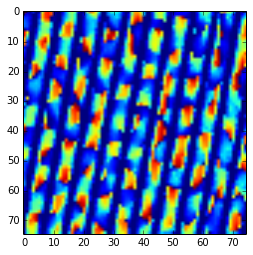

In [3]:
# Determine the connection probabilities 

N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs, False)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# load from Bryan's code
data = scipy.io.loadmat('orientation-map.mat')
OP_map = data['map']
plt.imshow(OP_map)
plt.colorbar()
plt.title('Orientation Preferences')

# Make an ocular dominance map based on complex cell distribution in 
# layer 3, Hubel and Wiesel 1968, fig. 14, wherein cells are divided into
# 7 groups, 1 meaning total preference for the ipsilateral eye, and 7 for
# total contralateral dominance
# TODO: make this make correlate with OP map some how (see Blasdel, 1993)
OD_dist = np.array([26., 22., 17., 9., 30., 37., 35.])
OD_prop = OD_dist/np.sum(OD_dist)
OD_cumul = np.cumsum(OD_prop)

# for now, just model as a sinusoid:
vals = np.linspace(-np.pi, np.pi, N_pairs)
ODx, ODy = np.meshgrid(vals, vals)

# rotate the sinusoid slightly:
OD_theta = 10*np.pi/180
OD_freq = 10
ODxy = np.cos(OD_theta)*ODx + np.sin(OD_theta)*ODy
OD_shape = 0.5*(np.sin(OD_freq * ODxy) + 1) # normalize the sinusoid
OD_map = np.zeros_like(OD_shape)
OD_scale_map = np.copy(OD_map)

# c_scale = np.linspace(0, 1, len(OD_dist), endpoint=True)
# i_scale = c_scale[::-1]

# assign each unit a OD group based on its value in the sinusoid
for i in range(len(OD_cumul)):
    if i == 0:
        OD_map[ np.where( OD_shape < OD_cumul[i] ) ] = i
    elif i == len(OD_cumul)-1:
        OD_map[ np.where( OD_shape >= OD_cumul[i-1] ) ] = i
    else:
        OD_map[ np.where( np.logical_and(OD_shape >= OD_cumul[i-1], OD_shape < OD_cumul[i]) ) ] = i
        
#normalize OD map
OD_map = OD_map/np.max(OD_map)
        
plt.figure()
plt.imshow(OD_map)
plt.colorbar()
plt.title('Ocular Dominance Preference')

plt.figure()
plt.imshow(OD_map*OP_map)

<matplotlib.colorbar.Colorbar instance at 0x7f6e881d9cb0>

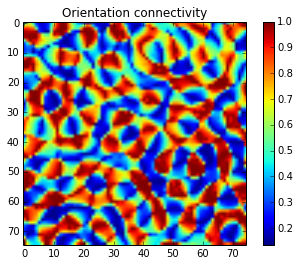

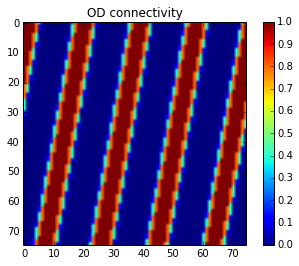

In [71]:
sig_ori = 45 # degrees...
G_ori = G(OP_map[33,33], OP_map, sig_ori)

#normalize OD map
OD_map = OD_map/np.max(OD_map)

sig_OD = .25
G_OD = G(OD_map[33,33], OD_map, sig_OD)

plt.figure()
plt.imshow(G_ori)
plt.title('Orientation connectivity')
plt.colorbar()

plt.figure()
plt.imshow(G_OD)
plt.title('OD connectivity')
plt.colorbar()

In [4]:
# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5

# kappa_E = 0.2
# kappa_I = 1.0

J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45
sig_OD = .25

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)

# may not need these
G_EI = np.copy(G_EE)
G_II = np.copy(G_EE)

G_ori = np.copy(G_EE)
G_OD = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

# iterate through each E/I pair:
for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        G_EI[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EI)
        G_II[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_II)
        
        G_ori[N_pairs*i+j,:,:] = G(OP_map[j,i], OP_map, sig_ori)
        
        # Does ocular dominance affect connectivity? 
        # Not according to Lowel and Singer, 1992, pg. 210-11:
        # "Analyses... provided no evidence for eye-specific selectivity of tangential connections"
        # Leaving this commented for future experiments though:
#         G_OD[N_pairs*i+j,:,:] = G(OD_map[j,i], OD_map, sig_OD)
        
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    pW_EI[i,:,:] = kappa_I * np.multiply(G_EI[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_II[i,:,:], G_ori[i,:,:])
      # for OD connectivity experiements:
#     pW_EE[i,:,:] = kappa_E * G_EE[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_IE[i,:,:] = kappa_E * G_IE[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_EI[i,:,:] = kappa_I * G_EI[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_II[i,:,:] = kappa_I * G_II[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

In [5]:
# Print mean number of connections:
print u_EE, u_IE, u_EI, u_II

20.1328 41.1607111111 28.2376888889 28.1884444444


In [6]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
for i in range(N_pairs**2):
    if np.all(W_EE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EE[i,:,:] = W_EE[i,:,:]*J_EE*u_EE/np.sum(W_EE[i,:,:])
    
    if np.all(W_IE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_IE[i,:,:] = W_IE[i,:,:]*J_IE*u_IE/np.sum(W_IE[i,:,:])

    if np.all(W_EI[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EI[i,:,:] = W_EI[i,:,:]*J_EI*u_EI/np.sum(W_EI[i,:,:])

    if np.all(W_II[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_II[i,:,:] = W_II[i,:,:]*J_II*u_II/np.sum(W_II[i,:,:])

In [7]:
# Model parameters (from supplementary methods)
sig_FF = 32
sig_RF = dx

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [8]:
# From S.1.3.2: for strongest nonlinear behaviour, omega_E < 0 and omega_E < omega_I
# where omega_E = sum(W_II) - sum(W_EI), omega_I = sum(W_IE) - sum(W_EE)
# Verify here:

omega_E = np.sum(W_II) - np.sum(W_EI)
omega_I = np.sum(W_IE) - np.sum(W_EE)

print 'Omega_E: ', omega_E
print 'Omega_I: ', omega_I

if omega_E < 0 and omega_I > omega_E:
    print "System should show strong nonlinear behaviour!"
else:
    print "System may not show strong nonlinear behaviour."

Omega_E:  1085.267
Omega_I:  76656.32
System may not show strong nonlinear behaviour.


In [9]:
# generate external drive for an oriented grating stimulus (circular or full frame)
# ori- orientation (degrees)
# size - diameter (degrees)
# centre - position in field of centre of stimulus (degrees, fsize/2 being the centre of the stimulus)
# ocularity - a scaling factor for which eye the stimulus is presented to (1 = contralateral, 0 = ipsilateral) 
# sig_RF - sigma for the stimulus mask
# sig_FF - sigma for full field
# fsize - size of field (degrees, square field)
# full_frame - bool for using the full frame instead of a mask
def generate_ext_stimulus(ori, size, centre, ocularity, sig_RF=16./75, sig_FF = 32., fsize=16., full_frame=False):
    if ocularity != 0 and ocularity != 1:
        raise ValueError('Ocularity must be either 0 (ipsilateral) or 1 (contralateral).')
    
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
    
    G_FF = G(ori, OP_map, sig_FF)
    
    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        mask = stimulus_mask(dist, size, sig_RF)
        h = np.multiply( mask, G_FF )
    
    if ocularity == 1:
        h = h * OD_map
    else:
        h = h * np.abs(OD_map-1)
    
    return h

def generate_mono_stimulus(ori, size, centre, sig_RF=16./75, sig_FF = 32., fsize=16., full_frame=False):
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
        
    G_FF = G(ori, OP_map, sig_FF)
    
    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        mask = stimulus_mask(dist, size, sig_RF)
        h = np.multiply( mask, G_FF )
    
    return h

# generate external drive for an annular stimulus for surround suppression experiments
# orientation - of the stimulus (degrees)
# inner_d - inner diameter of the stimulus (degrees)
# outer_d - inner diameter of the stimulus (degrees)
# ocularity - a scaling factor for which eye the stimulus is presented to (1 = contralateral, 0 = ipsilateral)
# centre - about which the ring is placed
def generate_ring_stimulus(orientation, inner_d, outer_d, centre, ocularity, sig_RF=16./75, sig_FF = 32., fsize=16.):
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
        
    if ocularity != 0 and ocularity != 1:
        raise ValueError('Ocularity must be either 0 (ipsilateral) or 1 (contralateral).')
    
    if inner_d >= outer_d:
        raise ValueError('Inner diameter must be less than the outer diameter (duh).')
    
    G_FF = G(ori, OP_map, sig_FF)

    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    x_distance = np.abs(xv - centre[0])
    y_distance = np.abs(yv - centre[1])
    dist = np.sqrt(x_distance**2 + y_distance**2)
    
    ring_mask = stimulus_mask(dist, outer_d, sig_RF) - stimulus_mask(dist, inner_d, sig_RF)
    
    if ocularity == 1:
        h = ring_mask * G_FF * OD_map
    else:
        h = ring_mask * G_FF * np.abs(OD_map-1)
        
    return h

In [10]:
def run_simulation( dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II, init_cond=[np.zeros((N_pairs, N_pairs)),np.zeros((N_pairs, N_pairs))]):
    r_E = np.zeros((timesteps, N_pairs, N_pairs))
    r_I = np.copy(r_E)

    # add initial conditions:
    r_E[0,:,:] = init_cond[0]
    r_I[0,:,:] = init_cond[1]

    I_E = np.zeros((timesteps, N_pairs, N_pairs))
    I_I = np.copy(I_E)
    # rSS_E = np.copy(I_E)
    # rSS_I = np.copy(I_I)

    for t in range(1,timesteps):
        # Input drive from external input and network
        I_E[t,:,:] = c*h + np.sum( np.sum( W_EE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_EI * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        I_I[t,:,:] = c*h + np.sum( np.sum( W_IE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_II * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        
        # steady state firing rates - power law I/O
        rSS_E = np.multiply(k, np.power(np.fmax(0,I_E[t,:,:]), n_E))
        rSS_I = np.multiply(k, np.power(np.fmax(0,I_I[t,:,:]), n_I))

        # set negative steady state rates to zero
        rSS_E[rSS_E < 0] = 0
        rSS_I[rSS_I < 0] = 0

        # instantaneous firing rates approaching steady state
        r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
        r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))
        
    return [r_E, r_I, I_E, I_I]

In [11]:
# For a given set of weights, find units that show strong surround suppression
# Surround suppression index (SSI) as defined by Rubin et al, 2015:
# SSI = r_max - r_full / r_max, where r_max is the max firing rate to stimuli shorter
# than 2/3 of full field, and r_full = firing rate at full field 
def find_SS_units(W_EE, W_EI, W_IE, W_II, OP_map, h_bank, r_units, SSI_thresh=0.25, N_pairs=75, fsize=16.):

    c = 40
    dt = 0.005
    timesteps = 100
    
    n_samples = len(r_units)
    
    if n_samples > W_EE.size:
        raise ValueError("Number of samples must be less than or equal to the number of units")
    
    # keep two lists of units which show strong surround suppression
    SS_E = np.empty((0,2))
    SS_I = np.empty((0,2))
                      
    results_E = np.zeros((n_samples, h_bank.shape[1]))
    results_I = np.zeros((n_samples, h_bank.shape[1]))                      
                      
    for i in range(n_samples):
        xi = r_units[i,0]
        yi = r_units[i,1]         
        r_E_max = 0
        r_I_max = 0                   
        for j in range(h_bank.shape[1]):
            h = h_bank[i,j,:,:]
            [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
            
            results_E[i,j] = r_E[-1,yi,xi]
            results_I[i,j] = r_I[-1,yi,xi]
                      
            if r_E_max < r_E[-1,yi,xi]: 
                r_E_max = r_E[-1,yi,xi]

            if r_I_max < r_I[-1,yi,xi]:
                r_I_max = r_I[-1,yi,xi]              
        
        r_E_ff = r_E[-1,yi,xi]
        if (r_E_max - r_E_ff)/r_E_max > SSI_thresh:
            SS_E = np.append(SS_E, [r_units[i,:]], axis=0)
                             
        r_I_ff = r_I[-1,yi,xi]
        if (r_I_max - r_I_ff)/r_I_max > SSI_thresh:
            SS_I = np.append(SS_I, [r_units[i,:]], axis=0)                             
                      
        
    return [SS_E, SS_I, results_E, results_I]

In [15]:
# randomly select n units:
n_samples = 25
r_units = np.floor(N_pairs*np.random.rand(n_samples, 2))

fsize = 16.
N_pairs = 75
dx = fsize/N_pairs

# generate the external drive bank with a full frame stimulus at the end
stim_sizes = np.linspace(0.5, 16.*2/3., 10)
h_bank = np.zeros((n_samples, len(stim_sizes)+1, N_pairs, N_pairs ) )
for i in range(n_samples):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(stim_sizes)):
        h_bank[i,j,:,:] = generate_mono_stimulus(OP_map[yi,xi], stim_sizes[j], [dx*xi,dx*yi])

    h_bank[i,-1,:,:] = generate_mono_stimulus(OP_map[yi,xi], 0, [0,0], full_frame=True)

In [16]:
start_time = time.time()
[SS_E, SS_I, results_E, results_I] = find_SS_units(W_EE, W_EI, W_IE, W_II, OP_map, h_bank, r_units)
print "Elapsed time: ", time.time()-start_time
print "%d E units and %d I units show strong surround suppression." % (len(SS_E), len(SS_I))
print SS_E
print '============'
print SS_I

Elapsed time:  9585.57112408
26 E units and 11 I units show strong surround suppression.
[[ -1.  -1.]
 [ 66.  54.]
 [ 49.  11.]
 [ 59.  52.]
 [ 62.  26.]
 [ 52.  17.]
 [ 42.  41.]
 [ 44.  56.]
 [ 15.  68.]
 [ 41.  34.]
 [ 35.  49.]
 [ 40.  18.]
 [ 31.  58.]
 [ 52.  40.]
 [ 65.   3.]
 [ 35.  33.]
 [ 34.   0.]
 [ 48.  43.]
 [ 55.  58.]
 [ 60.  28.]
 [ 72.  45.]
 [  8.  23.]
 [ 64.  66.]
 [ 49.   2.]
 [ 32.  26.]
 [ 65.  21.]]
[[ -1.  -1.]
 [ 66.  54.]
 [ 59.  52.]
 [ 62.  26.]
 [ 42.  41.]
 [ 15.  68.]
 [ 35.  33.]
 [ 34.   0.]
 [ 55.  58.]
 [  8.  23.]
 [ 49.   2.]]


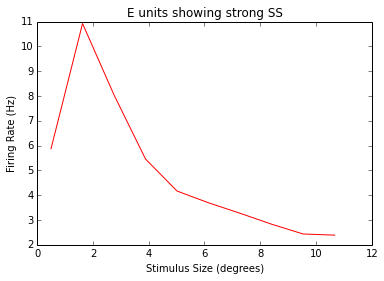

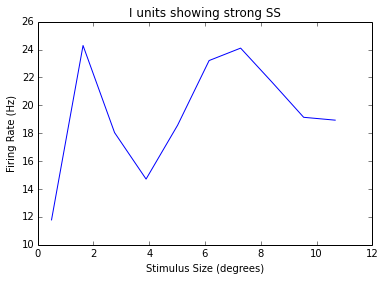

In [38]:
# Reproduce figure 6E using the identified neurons:

# convert the lists to scalar indices for ease of comparison
r_inds = r_units[:,0] + r_units[:,1]*N_pairs
E_inds = SS_E[:,0] + SS_E[:,1]*N_pairs
I_inds = SS_I[:,0] + SS_I[:,1]*N_pairs

r_SSI_E = np.empty( (0,1) )
for i in E_inds:
    r_SSI_E = np.append( r_SSI_E, np.where(i==r_inds), axis=0 )

plt.figure()
plt.plot(stim_sizes, np.mean(results_E[r_SSI_E.flatten().astype(int),:-1],0), 'r')
plt.title("E units showing strong SS")
plt.xlabel("Stimulus Size (degrees)")
plt.ylabel("Firing Rate (Hz)")

plt.savefig('results/fig6e-OD-E-units-%dof%d' %  (len(E_inds), n_samples)) 
r_SSI_I = np.empty( (0,1) )
for i in I_inds:
    r_SSI_I = np.append( r_SSI_I, np.where(i==r_inds), axis=0 )
  
plt.figure()
plt.plot(stim_sizes, np.mean(results_I[r_SSI_I.flatten().astype(int),:-1], 0), 'b')
plt.title("I units showing strong SS")
plt.xlabel("Stimulus Size (degrees)")
plt.ylabel("Firing Rate (Hz)")

plt.savefig('results/fig6e-OD-I-units-%dof%d' %  (len(I_inds), n_samples))

In [31]:
# randomly select 10 neurons with strong OD and strong SS and generate stimuli for them:
OD_vals = np.linspace(0,1,7,True)
# OD_units = np.where( np.logical_or(OD_map <= OD_vals[1], OD_map >= OD_vals[-2]) )

OD_units = np.empty( (0,2) )
for i in SS_E:
    if np.logical_or(OD_map[i[1], i[0]] <= OD_vals[1], OD_map[i[1], i[0]] >= OD_vals[-2]):
        i = i.reshape(1,2) 
        OD_units = np.append(OD_units, i, axis=0)       

# r_units = np.floor(len(OD_units[0])*np.random.rand(10, 2))
# xinds = OD_units[1][r_units[:,0].astype(int)]
# yinds = OD_units[0][r_units[:,1].astype(int)]

xinds = OD_units[:,0]
yinds = OD_units[:,1]

# store stimuli for the dominant eye CRF, dominant eye surround, and non-dominant eye surround
h_bank = np.zeros((N_pairs, N_pairs, len(OD_units), 3))

# stimulus parameters - based on Webb et al., 2005: 
crf_d = 0.5

# try to use an inner diameter that will evoke no response:
inner_d = 24*dx # twice the sig_IE
outer_d = 8

# generate stimulus bank
for i in range(len(OD_units)):
    
    ori = OP_map[ yinds[i], xinds[i] ]
    centre = [dx*xinds[i], dx*yinds[i]]
    
    ocularity = np.round(OD_map[yinds[i], xinds[i]])
    
    h_surr_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, ocularity)
    
    h_crf = generate_ext_stimulus(ori, crf_d, centre, ocularity)
    
    h_surr_non_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, np.abs(ocularity-1))
    
#     plt.figure()
#     plt.imshow(h_crf)
#     plt.title('CRF drive')

#     plt.figure()
#     plt.imshow(h_surr_dom)
#     plt.title('Dominant Eye Surround drive')

#     plt.figure()
#     plt.imshow(h_surr_non_dom)
#     plt.title('Non-dominant Eye Surround drive')
    
    h_bank[:,:,i,0] = h_crf
    h_bank[:,:,i,1] = h_surr_dom
    h_bank[:,:,i,2] = h_surr_non_dom

In [33]:
# Run simulations to reproduce fig 10A of Webb et al., 2005

dt = 0.005
timesteps = 100
c = 50

results_r_E = np.zeros((len(OD_units), 3, timesteps, N_pairs, N_pairs))
results_r_I = np.copy(results_r_E)
results_I_E = np.copy(results_r_E)
results_I_I = np.copy(results_r_E)

start_time = time.time()
for i in range(len(OD_units)):
    # simulation for CRF only:
    h = h_bank[:,:,i,0]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,0,:,:,:] = r_E
    results_r_I[i,0,:,:,:] = r_I
    results_I_E[i,0,:,:,:] = I_E
    results_I_I[i,0,:,:,:] = I_I
        
    # simulation for CRF and dominant-eye surround:
    h = h_bank[:,:,i,0] + h_bank[:,:,i,1]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,1,:,:,:] = r_E
    results_r_I[i,1,:,:,:] = r_I
    results_I_E[i,1,:,:,:] = I_E
    results_I_I[i,1,:,:,:] = I_I
        
    # simulation for CRF and non-dominant-eye surround:
    h = h_bank[:,:,i,0] + h_bank[:,:,i,2]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,2,:,:,:] = r_E
    results_r_I[i,2,:,:,:] = r_I
    results_I_E[i,2,:,:,:] = I_E
    results_I_I[i,2,:,:,:] = I_I
    
print "Elasped time: ", time.time() - start_time

Elasped time:  1548.64789701


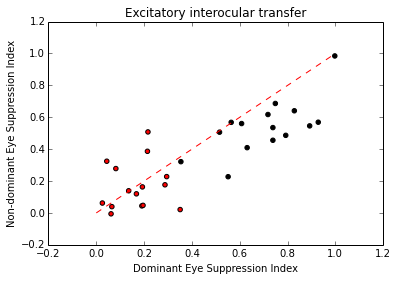

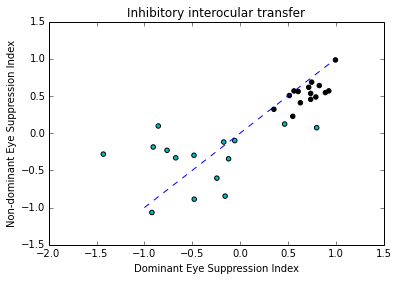

In [37]:
# Calculate suppression index (SI) for each neuron
# From Webb et al., 2005, pg. 11667:
# SI = R_pref - R_pref+annulus / R_pref

# Reproducing fig 10A: transfer ratio:
# non-dominant SI / dominant SI
# median transfer ratio: 0.77 +/- 0.05

r_pref_E = np.zeros(len(OD_units))
r_dom_E = np.copy(r_pref_E)
r_nd_E = np.copy(r_pref_E)
r_pref_I = np.zeros(len(OD_units))
r_dom_I = np.copy(r_pref_I)
r_nd_I = np.copy(r_pref_I)

for i in range(len(OD_units)):
    r_pref_E[i] = results_r_E[i,0,-1,yinds[i],xinds[i]]
    r_dom_E[i]  = results_r_E[i,1,-1,yinds[i],xinds[i]]
    r_nd_E[i]   = results_r_E[i,2,-1,yinds[i],xinds[i]]
    
    r_pref_I[i] = results_r_I[i,0,-1,yinds[i],xinds[i]]
    r_dom_I[i]  = results_r_I[i,1,-1,yinds[i],xinds[i]]
    r_nd_I[i]   = results_r_I[i,2,-1,yinds[i],xinds[i]]

r_pref_I = np.round(r_pref_I)

dom_SI_E = (r_pref_E - r_dom_E)/r_pref_E
nd_SI_E = (r_pref_E - r_nd_E)/r_pref_E
                         
# Data from Webb et al., 2005, fig 10A:
webb_data = np.array([[0.3538, 0.3214],
[0.5513, 0.2271],
[0.5154, 0.5064],
[0.5641, 0.5681],
[0.6077, 0.5605],
[0.7179, 0.6172],
[0.7487, 0.6865],
[0.8282, 0.6406],
[0.8923, 0.5459],
[0.9282, 0.5690],
[0.6308, 0.4093],
[0.7385, 0.4557],
[0.7923, 0.4866],
[0.7385, 0.5352],
[0.9974, 0.9846]])
    
plt.figure()
plt.scatter(dom_SI_E, nd_SI_E, c='r')
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.plot([0,1], [0,1], 'r--')
plt.title('Excitatory interocular transfer')
plt.xlabel("Dominant Eye Suppression Index")
plt.ylabel("Non-dominant Eye Suppression Index")
plt.savefig('results/fig-10a_SI_E-c%d-id%d-od%d-ODF-%d-SSI' % (c,inner_d, outer_d,OD_freq) )

dom_SI_I = (r_pref_I - r_dom_I)/r_pref_I
nd_SI_I = (r_pref_I - r_nd_I)/r_pref_I

plt.figure()
plt.scatter(dom_SI_I, nd_SI_I, c='c')
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.plot([-1,1], [-1,1], 'b--')
plt.xlabel("Dominant Eye Suppression Index")
plt.ylabel("Non-dominant Eye Suppression Index")
plt.title('Inhibitory interocular transfer')

plt.savefig('results/fig-10a_SI_I-c%d-id%d-od%d-ODF-%d-SSI' % (c,inner_d, outer_d, OD_freq) )

In [31]:
print r_pref_I
print r_dom_I
print r_nd_I

print np.round(r_pref_I)

[  6.98683035e+01   1.19235943e-24   2.34842365e+01   3.35039619e+01
   3.29560885e+01   2.76170238e+01   1.59793645e+01   3.40978580e+01
   2.13001027e+01   4.81721685e+01]
[ 78.0027033    5.98399112  20.04970555  24.8144943   29.14411834
  17.00474335  22.16210055  40.74464869   2.12187609   3.41737484]
[  6.94353858e+01   3.05480962e-24   3.05277147e+01   3.43797973e+01
   3.27499188e+01   2.42546248e+01   1.69580884e+01   3.48374522e+01
   1.96843036e+01   4.36943508e+01]
[ 70.   0.  23.  34.  33.  28.  16.  34.  21.  48.]


27 22
(75, 75)


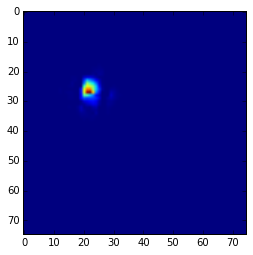

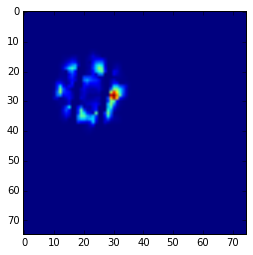

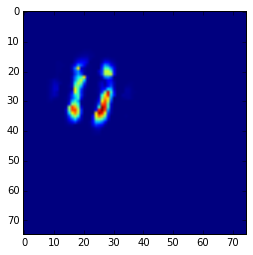

In [92]:
print yinds[1], xinds[1]

print h_bank[:,:,1,0].shape


plt.figure()
plt.imshow(h_bank[:,:,1,0])

plt.figure()
plt.imshow(h_bank[:,:,1,1])

plt.figure()
plt.imshow(h_bank[:,:,1,2])

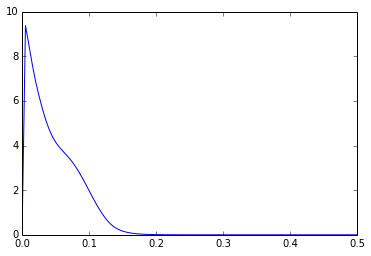

In [36]:
plt.plot(np.linspace(0,dt*timesteps,timesteps), results_r_E[1,0,:,73,8])